# Brain scanner classification

***

# Summary:
### I. Data Exploration
1) Images exploration <br>
2) Labels exploration <br>
### II. Data Preprocessing
1) Formatting the dataframe<br>
2) Data pipeline 1: Defining functions loading images and feeding images (model.fit used for 1st model) <br>
3) Data Pipeline 2: Feeding models with batches of images (model.fit_generator used for 2nd, 3rd and 4th model)
### III. Building and training neural networks
1) 1st Neural Network <br>
2) 2nd Neural Network <br>
3) 3rd Neural Network <br>
4) 4th Neural Network <br>
### IIV. Predictions on test data


***

### Import necessary libraries

In [145]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
import numpy as np

from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


import tensorflow as tf
from tensorflow import keras

from keras_preprocessing.image import ImageDataGenerator
# from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
# from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.utils import plot_model

***

# I) Data exploration

## I.1) Images exploration

float32
(128, 128)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


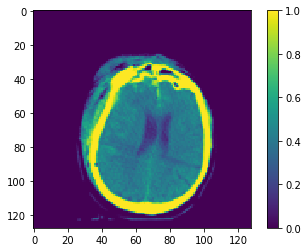

In [146]:
# load the first image of the  data set as pixel array
photo_0 = image.imread('train_images/train_images/train_0.png')

# summarize shape of the pixel array
print(photo_0.dtype)
print(photo_0.shape)
# print(photo_0.format)
print(photo_0)
# photo = photo.flatten()
# print(photo.shape)

# display the array of pixels as an image
plt.imshow(photo_0)
plt.colorbar()
plt.show()


## I.2) Labels exploration

In [147]:
# Read training set labels from filename.csv
df = pd.read_csv('behold_coding_challenge_train.csv')

# Rename column for convenience
df = df.rename(columns={'epidural': 'epi'}) 
df = df.rename(columns={'intraparenchymal': 'int'}) 
df = df.rename(columns={'subarachnoid': 'sub'}) 

# Output 
print('Quick view of the data in the csv file')
df

Quick view of the data in the csv file


,Unnamed: 0,ID,epi,int,sub
0,0,train_0,1,0,1
1,1,train_1,1,0,0
2,2,train_2,1,0,1
3,3,train_3,1,0,1
4,4,train_4,1,0,0
...,...,...,...,...,...
8537,8588,train_8588,0,0,0
8538,8589,train_8589,0,0,0
8539,8590,train_8590,0,0,0
8540,8591,train_8591,0,0,0


Let's get some more insights from the dataset and check for missing data

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8542 entries, 0 to 8541
Data columns (total 5 columns):
Unnamed: 0    8542 non-null int64
ID            8542 non-null object
epi           8542 non-null int64
int           8542 non-null int64
sub           8542 non-null int64
dtypes: int64(4), object(1)
memory usage: 333.8+ KB


Fortunately, there is no missing data, after double check in the csv file, we can move on.

classes dataframe
     epi int sub classes
0      1   0   1     101
1      1   0   0     100
2      1   0   1     101
3      1   0   1     101
4      1   0   0     100
...   ..  ..  ..     ...
8537   0   0   0     000
8538   0   0   0     000
8539   0   0   0     000
8540   0   0   0     000
8541   0   0   0     000

[8542 rows x 4 columns]
Classes count
000    3463
010    1873
001    1654
011    1211
100     180
110      68
101      53
111      40
Name: classes, dtype: int64


Text(0.5, 1.0, 'Count Plot of classes in decreasing order')

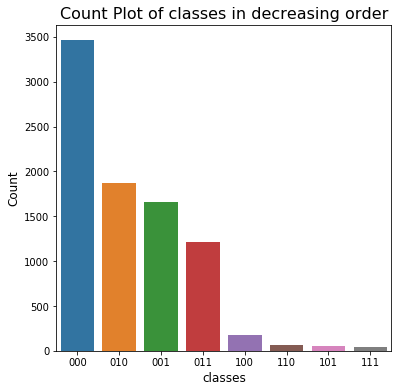

In [149]:
# Creating a string column in the dataframe giving the different classes of the brain damage:
# '000': No brain damage diagnosed
# '001': epi
# '010': int
# '100': sub
# '101': epi and sub
# '110': epi and int
# '011': int and sub
# '111': epi, int and sub

classes = pd.DataFrame(df[['epi','int','sub']])
classes = classes.applymap(str)
classes['classes'] = classes[['epi','int','sub']].apply(lambda x: ''.join(x), axis=1)
print('classes dataframe')
print(classes)


# Count the classes
print('Classes count')
print(classes['classes'].value_counts())


# Plotting countplot of the different classes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.countplot(x='classes', data=classes, order = ['000','010','001','011','100','110','101','111'])
ax.set_xlabel('classes', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Count Plot of classes in decreasing order', fontsize=16)


#### Note: If we assume that we collected the patient brain damage scanner in an unbiased and independent way, and the data captures somehow the real distribution, it is interesting to notice the number of '100' is pretty low, while the number of combination of '011' is pretty high. We can therefore think of these following assumptions:
- '100' is a rarer brain damage
- The combination of '001' and '010' brain damage which result in '011' class is not rare compared to the other combinations. There may be a correlationg between them.

***

# II) Data Preprocessing

I started to look into the data, and I realized several things, and I believe 4 things draw my attention:

__1)__ At first sight, one may believe that the 1st column gives the ID of the patient and match the ID of the second column, but there are some errors, and this column is not reliable. It can be observed it in this picture below:
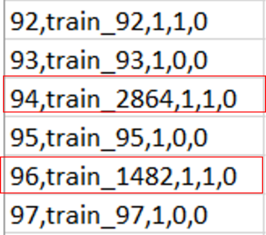

__2)__ There is in total 8543 rows in the csv file giving the label of the scanners. However, there are 8592 images in the training images file. Therefore, there are missing labels and we won't be able to use every image. The image for which we don't have the labels can probably be used in the test dataset. (There are around 50 images in the training set without labels) 

__3)__ In the test image dataset, the last image name is 'test_4037.png', but there is only 4019 elements in the folder. This means that there is some missing photos in the test dataset. For instance test_4.png is missing.

__4)__ The dataframe is going to be transformed into a dataframe with 5 columns:
- 'ID': integer variable, ID of the patient's brain scanner
- 'training_ID_path': image file path, giving the image file path to simplify image loading (the id in the image name should match the 'ID' on the same row)
- 'epi': binary variable, giving the presence or not of 'Epidural hematoma'
- 'int': binary variable, giving the presence or not of 'Subarachnoid hemorrhage'
- 'sub': binary variable, giving the presence or not of 'Intraparenchymal hemorrhage'
- 'labels': string, giving the label of the data
- 'labels_int': integer between 0 and 7, each integer correspond to one class. This step is necessary before feeding the labels to the model. A correspondance table will be given for clarity purpose.

## II. 1) Formatting the dataframe


In [150]:
# Read training set labels from filename.csv
df = pd.read_csv('behold_coding_challenge_train.csv')


# Dropping first column that is Unnamed since it doesn't give the real ID of the patient
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]


# Rename columns and duplicate an ID column from the real 'ID' column of the csv file. 
# This will ensure that only the images that have labels are kept

df = df.rename(columns={'ID': 'train_ID_path'})
df = df.rename(columns={'epidural': 'epi'}) 
df = df.rename(columns={'intraparenchymal': 'int'}) 
df = df.rename(columns={'subarachnoid': 'sub'}) 
ID = df['train_ID_path']         
df.insert(0, 'ID', ID) 


# Deleting string 'train_' in the 'ID' column, convert into integers and sort by ID
df['ID'] = df['ID'].str.replace('train_',' ') 
df['ID'] = df['ID'].astype(int)
df = df.sort_values(by=['ID'])


# Formatting the train_ID_path column into the image file path
df['train_ID_path'] = 'train_images/train_images/' + df['train_ID_path'].astype(str) + '.png'


# Create labels column
labels = pd.DataFrame(df[['epi','int','sub']])
labels = classes.applymap(str)
labels['labels'] = labels[['epi','int','sub']].apply(lambda x: ''.join(x), axis=1)
df.insert(5, 'labels', labels['labels']) 


# Encode the classes into integer label before feeding
d = {'label': [0,1,2,3,4,5,6,7], 'class': ['000','001','010','011','100','101','110','111']}
label_correspondance = pd.DataFrame(data=d)
print('Correspondance table:')
print(label_correspondance)

le = preprocessing.LabelEncoder()
le.fit(['000','001','010','011','100','101','110','111'])
list(le.classes_)
labels_int = le.transform(df['labels'])
df.insert(6, 'labels_int', labels_int) 


# Output 
df

Correspondance table:
   label class
0      0   000
1      1   001
2      2   010
3      3   011
4      4   100
5      5   101
6      6   110
7      7   111


,ID,train_ID_path,epi,int,sub,labels,labels_int
0,0,train_images/train_images/train_0.png,1,0,1,101,5
1,1,train_images/train_images/train_1.png,1,0,0,100,4
2,2,train_images/train_images/train_2.png,1,0,1,101,5
3,3,train_images/train_images/train_3.png,1,0,1,101,5
4,4,train_images/train_images/train_4.png,1,0,0,100,4
...,...,...,...,...,...,...,...
8537,8588,train_images/train_images/train_8588.png,0,0,0,000,0
8538,8589,train_images/train_images/train_8589.png,0,0,0,000,0
8539,8590,train_images/train_images/train_8590.png,0,0,0,000,0
8540,8591,train_images/train_images/train_8591.png,0,0,0,000,0


## II. 2) Defining functions loading images and feeding images (for Model.fit in the 1st model)

__Function 'load_image'__ is a function taking a image_path as input, and giving the matrix of the image pixel values as output

In [151]:
def load_image(path):
    img = image.imread(path)
    return img

In [152]:
# Train-validation split

# Preparing the image matrix
x = df['train_ID_path']
x = list(np.array(x))
X = []

for i in range(len(x)):
    X += [list(load_image(x[i]))]
X = np.array(X)


# Preparing the label matrix
y = np.array(df['labels_int'])


# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)



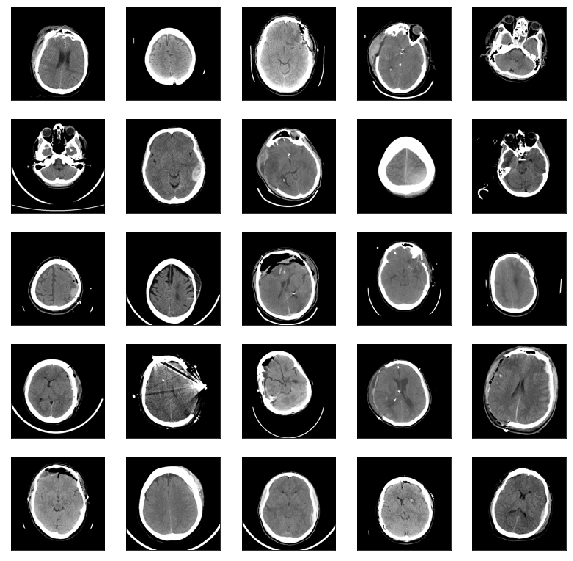

In [153]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i],cmap = 'gray')
plt.show()

## II.3) Data Pipeline: feeding models with batches of images (model.fit_generator used for 2nd, 3rd and 4th model)

#### Training images

In [73]:
# Read training set labels from filename.csv
df = pd.read_csv('behold_coding_challenge_train.csv')

# Rename column for convenience
df = df.rename(columns={'ID': 'filename'}) 
df = df.rename(columns={'epidural': 'epi'}) 
df = df.rename(columns={'intraparenchymal': 'int'}) 
df = df.rename(columns={'subarachnoid': 'sub'}) 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df['filename'] = df['filename'].astype(str) + '.png'

# Output 
df

,filename,epi,int,sub
0,train_0.png,1,0,1
1,train_1.png,1,0,0
2,train_2.png,1,0,1
3,train_3.png,1,0,1
4,train_4.png,1,0,0
...,...,...,...,...
8537,train_8588.png,0,0,0
8538,train_8589.png,0,0,0
8539,train_8590.png,0,0,0
8540,train_8591.png,0,0,0


#### Test images

In [116]:
test_image_path = "./test_images/test_images"
test_images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
test = pd.DataFrame(test_images,columns = ['filename'])

# Deleting string 'train_' in the 'filename' column, convert into integers and sort by id
test['filename'] = test['filename'].str.replace('test_','') 
test['filename'] = test['filename'].str.replace('.png','') 
test['filename'] = test['filename'].astype(int)
test = test.sort_values(by=['filename'])


# Formatting the train_ID_path column into the image file path
# test['filename'] = test['filename'].astype(str) + '.png'

# Output 
test

,filename
0,0
1,1
1104,2
2215,3
3472,5
...,...
3364,4033
3365,4034
3366,4035
3367,4036


#### Note: The file names are order in an increasing order in the dataframe now

### Building training, validation and test generators

In [75]:
columns=["epi", "int", "sub"]
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

# Test-validation dataset split
test_datagen=ImageDataGenerator(rescale=1./255.)

print('Training data:')
train_generator=datagen.flow_from_dataframe(
        dataframe=df,
        directory="./train_images/train_images",
        x_col="filename",
        y_col=columns,
        subset="training",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="other",
        target_size=(128,128),
        color_mode = "grayscale")


print('Validation data:')
valid_generator=datagen.flow_from_dataframe(
        dataframe=df,
        directory="./train_images/train_images",
        x_col="filename",
        y_col=columns,
        subset="validation",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="other",
        target_size=(128,128),
        color_mode = "grayscale")


print('Test data:')
test_generator=test_datagen.flow_from_dataframe(
        dataframe=test,
        directory="./test_images/test_images",
        x_col="filename",
        batch_size=1,
        seed=42,
        shuffle=False,
        class_mode=None,
        target_size=(128,128),
        color_mode = 'grayscale')

Training data:
Found 6834 validated image filenames.
Validation data:
Found 1708 validated image filenames.
Test data:
Found 4019 validated image filenames.


***

# III. Building and training Neural Networks

## III.1) 1st Neural network:
#### For this first neural network, I decided to classify the images in 8 classes: '000','001','010','011','100','101','110','111'
#### This is probably not the most appropriate way knowing that the classes are not independent between them, but it is a first try before engaging into more complex model.

In [154]:
model1 = keras.Sequential()
model1 = keras.Sequential([
        keras.layers.Flatten(input_shape=(128, 128)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(8, activation='softmax')
        ])

model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [157]:
history1 = model1.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val))

Train on 6833 samples, validate on 1709 samples
Epoch 1/3
6833/6833 [==============================] - 4s 553us/sample - loss: 1.2322 - accuracy: 0.4900 - val_loss: 1.3330 - val_accuracy: 0.4587s:
Epoch 2/3
6833/6833 [==============================] - 4s 559us/sample - loss: 1.2087 - accuracy: 0.5039 - val_loss: 1.3467 - val_accuracy: 0.4558
Epoch 3/3
6833/6833 [==============================] - 4s 581us/sample - loss: 1.1849 - accuracy: 0.5160 - val_loss: 1.3921 - val_accuracy: 0.4599


## III.2) Results - 1st Neural network :

In [155]:
model1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               2097280   
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 1032      
Total params: 2,098,312
Trainable params: 2,098,312
Non-trainable params: 0
_________________________________________________________________


### III.2) i) Learning curve

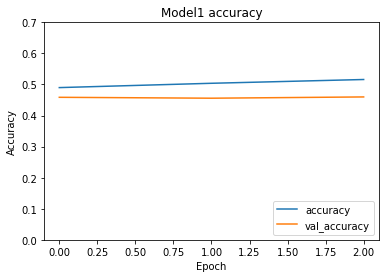

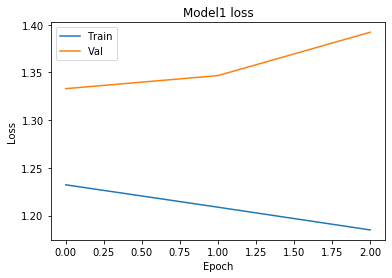

In [158]:
# Plot training & validation accuracy values
plt.plot(history1.history['accuracy'], label='accuracy')
plt.plot(history1.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model1 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 0.7])
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [159]:
val_loss, val_acc = model1.evaluate(X_val,  y_val, verbose=2)

print('\nValidation accuracy:', val_acc)

1709/1 - 0s - loss: 1.7424 - accuracy: 0.4599

Validation accuracy: 0.45991808


### III.2) ii) Confusion matrix and classification report

In [160]:
predictions = model1.predict(X_val)
y_pred = np.argmax(predictions, axis = 1)

print('Confusion Matrix')
print(confusion_matrix(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)

print('Classification Report')
target_names = ['000','001','010','011','100','101','110','111']
print(classification_report(y_val, y_pred, target_names = target_names))


Confusion Matrix
[[578  14  86  21   0   0   0   0]
 [195  25  78  28   0   0   0   0]
 [164  13 148  39   0   0   0   0]
 [ 96  13  96  35   0   0   0   0]
 [ 33   1  12   2   0   0   0   0]
 [  4   3   2   0   0   0   0   0]
 [  4   2   7   2   0   0   0   0]
 [  1   1   4   2   0   0   0   0]]
Classification Report
              precision    recall  f1-score   support

         000       0.54      0.83      0.65       699
         001       0.35      0.08      0.13       326
         010       0.34      0.41      0.37       364
         011       0.27      0.15      0.19       240
         100       0.00      0.00      0.00        48
         101       0.00      0.00      0.00         9
         110       0.00      0.00      0.00        15
         111       0.00      0.00      0.00         8

    accuracy                           0.46      1709
   macro avg       0.19      0.18      0.17      1709
weighted avg       0.40      0.46      0.40      1709



D:\anaconda\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### III.2) iii) Comparing distribution of validation data and prediction

Support: distribution in the validation data
000    699
010    364
001    326
011    240
100     48
110     15
101      9
111      8
Name: class, dtype: int64
Prediction of validation data
000    1075
010     433
011     129
001      72
Name: class, dtype: int64


Text(0.5, 1.0, 'Count Plot of classes from model1 predictions')

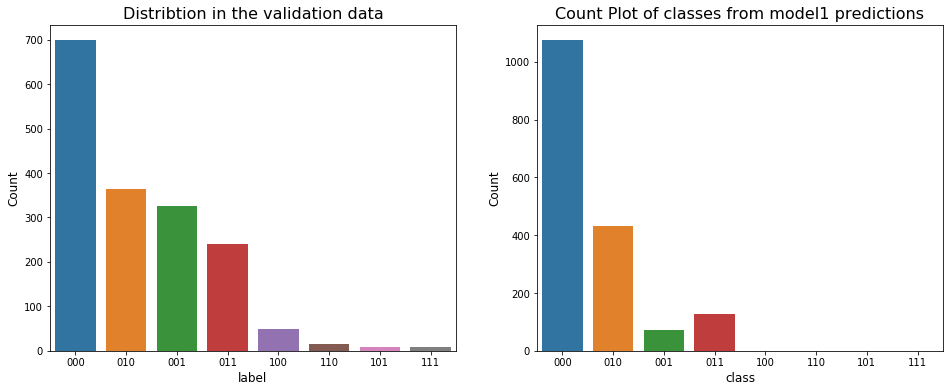

In [180]:
#=========================================================================================================================


print('Support: distribution in the validation data')
y_val1 = pd.DataFrame(y_val, columns = ['label'])
y_val1 = y_val1.merge(label_correspondance, on='label', how='left')

# Count the classes
print(y_val1['class'].value_counts())

# Plotting countplot of the distribution of the validation set of the different classes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='class', data=y_val1, order = ['000','010','001','011','100','110','101','111'],ax=ax[0])
ax[0].set_xlabel('label', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Distribtion in the validation data', fontsize=16)




#=========================================================================================================================

print('Prediction on validation data')
y_pred1 = pd.DataFrame(y_pred, columns = ['label'])
y_pred1 = y_pred1.merge(label_correspondance, on='label', how='left')

# Count the classes
print(y_pred1['class'].value_counts())

# Plotting countplot of the PREDICTION on validation set of the different classes
sns.countplot(x='class', data=y_pred1, order = ['000','010','001','011','100','110','101','111'],ax=ax[1])
ax[1].set_xlabel('class', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)
ax[1].set_title('Count Plot of classes from model1 predictions', fontsize=16)




### Note: The accuracy is not high with the training data and it's even lower with the validation dataset, there is some overfitting, but mostly the model need to be improved.<br> More complex models with convolutional layers will therefore need to be built in order to reach higher accuracy.

***

# III. 2) 2nd Neural Network: 
#### In this second Neural network, I chose to use a multi label classification with 3 output channels to recreate the output of the 3 types of brain damage.
#### 2 convolution layers and 2 dense layers are used in this structure.

In [80]:
model2 = keras.Sequential()

model2.add(keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu', input_shape=(128, 128, 1)))
model2.add(keras.layers.Conv2D(64, kernel_size=3, strides=1, activation='relu')) 
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(128, activation='relu'))
model2.add(keras.layers.Dense(3, activation='sigmoid'))

model2.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [81]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1)

# model2.fit_generator(generator=train_generator,
#                     steps_per_epoch = STEP_SIZE_TRAIN,
#                     epochs=1)

# model2.fit_generator(generator=valid_generator,
#                     steps_per_epoch = STEP_SIZE_VALID,
#                     epochs=1)

213/213 [==============================] - 145s 679ms/step - loss: 0.3811 - accuracy: 0.8008 - val_loss: 0.8926 - val_accuracy: 0.5142


### Results and analysis - 2nd Neural Network 

In [133]:
model2.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 62, 62, 32)        832       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
flatten_19 (Flatten)         (None, 230400)            0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               29491328  
_________________________________________________________________
dense_39 (Dense)             (None, 3)                 387       
Total params: 29,511,043
Trainable params: 29,511,043
Non-trainable params: 0
_________________________________________________________________


In [1]:
plot_model(model2, to_file='model2.png')

NameError: name 'plot_model' is not defined

# Note: plot the proportion of the 3 classes and confusion matrix

In [117]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [118]:
model2.evaluate_generator(generator=valid_generator,
                steps=STEP_SIZE_TEST)

[0.8916591662439904, 0.5140573]

***

# III. 3) 3rd Neural Network: 
### Multilabel classification with a more complex structure: Conv2D, Conv2D, Maxpooling2D, Conv2D, Conv2D, Maxpooling2D, Dense, Dense with sigmoid and binary cross_entropy

In [84]:
model3 = keras.Sequential()
model3.add(keras.layers.Conv2D(32, (3, 3), padding='same',activation='relu',input_shape=(128,128,1)))
model3.add(keras.layers.Conv2D(32, (3, 3),activation='relu'))
model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Dropout(0.25))

model3.add(keras.layers.Conv2D(64, (3, 3), padding='same',activation='relu',))
model3.add(keras.layers.Conv2D(64, (3, 3),activation='relu'))
model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(keras.layers.Dropout(0.25))
model3.add(keras.layers.Flatten())

model3.add(keras.layers.Dense(512, activation = 'relu'))
model3.add(keras.layers.Dropout(0.5))

model3.add(keras.layers.Dense(3, activation='sigmoid'))
model3.compile(keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])


In [85]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


model3.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1)

213/213 [==============================] - 628s 3s/step - loss: 0.3945 - accuracy: 0.7907 - val_loss: 0.7424 - val_accuracy: 0.4876


### Results and analysis - 3rd Neural Network 

In [134]:
model3.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 30, 30, 64)      

***

# III. 4) 4th Neural Network: Multi-label classification with a Multi-Output Model
### Multilabel classification with a more complex structure: Conv2D, Conv2D, Maxpooling2D, Conv2D, Conv2D, Maxpooling2D, Dense, Dense with sigmoid and binary cross_entropy

In [120]:
# we need to make here is to use Keras’s Function API instead of the Sequential API 
# because it doesn’t support multiple outputs and an extra wrapper function to return
# the target label array in the expected format.

inp = keras.Input(shape = (128,128,1))
x = keras.layers.Conv2D(32, (3, 3), padding = 'same',activation='relu')(inp)
# x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(32, (3, 3),activation='relu')(x)
# x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Conv2D(64, (3, 3), padding = 'same',activation='relu')(x)
# x = keras.layers.Activation('relu')(x)
x = keras.layers.Conv2D(64, (3, 3),activation='relu')(x)
# x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(512,activation='relu')(x)
# x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)

output1 = keras.layers.Dense(1, activation = 'sigmoid')(x)
output2 = keras.layers.Dense(1, activation = 'sigmoid')(x)
output3 = keras.layers.Dense(1, activation = 'sigmoid')(x)

model4 = keras.models.Model(inp,[output1,output2,output3])
model4.compile(keras.optimizers.RMSprop(lr = 0.0001, decay = 1e-6),
                loss = ["binary_crossentropy","binary_crossentropy","binary_crossentropy"],
                metrics = ["accuracy"])

In [121]:
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(3)])

In [122]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

model4.fit_generator(generator = generator_wrapper(train_generator),
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = generator_wrapper(valid_generator),
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 1,
                    verbose = 2)

213/213 - 624s - loss: 1.1857 - dense_61_loss: 0.0506 - dense_62_loss: 0.5243 - dense_63_loss: 0.6108 - dense_61_accuracy: 0.9910 - dense_62_accuracy: 0.7386 - dense_63_accuracy: 0.6392 - val_loss: 2.1319 - val_dense_61_loss: 0.5760 - val_dense_62_loss: 0.9195 - val_dense_63_loss: 0.6365 - val_dense_61_accuracy: 0.8290 - val_dense_62_accuracy: 0.1828 - val_dense_63_accuracy: 0.6610


### Results and analysis - 4th Neural Network 

In [135]:
model4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 128, 128, 32) 320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 126, 126, 32) 9248        conv2d_80[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 63, 63, 32)   0           conv2d_81[0][0]                  
____________________________________________________________________________________________

***

### Predictions for test_data

In [123]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()
pred=model4.predict_generator(test_generator,
                                steps=STEP_SIZE_TEST,
                                verbose=1)


4019/4019 [==============================] - 149s 37ms/step


In [129]:
pred_bool = (i for i in pred if i > 0.5)

In [126]:
predictions = pred_bool.astype(int)
columns=["epi", "int", "sub"]
#columns should be the same order of y_col
results=pd.DataFrame(predictions, columns=columns)
results["Filenames"]=test_generator.filenames
ordered_cols=["Filenames"]+columns
results=results[ordered_cols]#To get the same column order
results.to_csv("results.csv",index=False)

AttributeError: 'generator' object has no attribute 'astype'

In [ ]:
predictions = model.predict(test_images)
predictions[0]
threshold = 0.5
# make predictions for the test data and save the results

### Results and analysis

### Results and analysis

### Results and analysis